<a href="https://colab.research.google.com/github/yuyang147/Diabetic-Retinopathy-Detection/blob/master/dr_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy (DR) Detection

In [0]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install tensorflow==2.0.0

In [0]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [0]:
os.chdir('/content/drive/My Drive/fintech/DR_project/')

## Dataset

The dataset consists 1500 retina images. Each image is given a label which is the stage of diabetic retinopathy (DR): 0 - No DR, 1- Mild DR, 2 - Moderate DR, 3 - Severe DR, 4 - Proliferative DR.

The problem is treated as a 5-class classification task.

In [0]:
# Load labels
label_path = 'DR_data/labels.json'

with open(label_path, 'r') as f:
    labels = json.load(f)
label_dict = dict(labels)

In [0]:
# Load images
img_path = 'DR_data/images.zip'

images = []
labels = []

with ZipFile(img_path, 'r') as zip_f:
    for img_name in zip_f.namelist():
        with zip_f.open(img_name) as f:
            try:
                img = Image.open(f)
                images.append(img)
                labels.append(label_dict[img_name])
            except OSError:
                pass

print('{length} images have been loaded.'.format(length=len(images)))

1500 images have been loaded.


An example of loaded retina images is as follows.

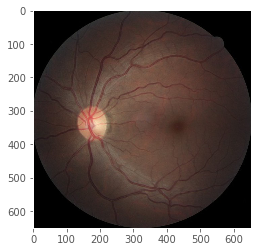

In [0]:
plt.imshow(images[100])
plt.grid()

The data is split into a training set and a test set, with 70% of the data as training data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=123)

print('Training set: {length} images.'.format(length=len(X_train)))
print('Test set: {length} images.'.format(length=len(X_test)))

Training set: 1050 images.
Test set: 450 images.


As we can see from below, the data are unbalanced, with 73.33% of the traing set and 72.22% of the test set having lavel 0.

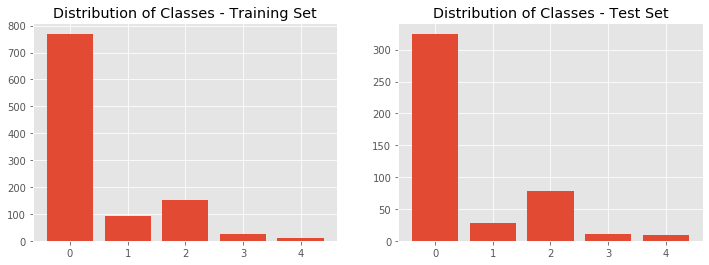

Training set: Stage 0 - 73.33%
Test set: Stage 0 - 72.22%


In [0]:
counts_train = pd.Series(y_train).value_counts(sort=False)
counts_test = pd.Series(y_test).value_counts(sort=False)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(counts_train.keys(), counts_train.values,)
axes[0].set_title('Distribution of Classes - Training Set')
axes[1].bar(counts_test.keys(), counts_test.values)
axes[1].set_title('Distribution of Classes - Test Set')
plt.show()

print('Training set: Stage 0 - {pct}%'.format(
    pct=round(counts_train[0]/len(y_train)*100, 2)))
print('Test set: Stage 0 - {pct}%'.format(
    pct=round(counts_test[0]/len(y_test)*100, 2)))

All images are resized to 256 * 256, and all three color channels are retained.

In [0]:
size = (256, 256)

func = lambda x: np.asarray(x.resize(size))
X_train = np.array(list(map(func, X_train)))
X_test = np.array(list(map(func, X_test)))
y_train = np.array(y_train)
y_test = np.array(y_test)

## Modeling

### Baseline

The baseline model simply predicts the class that has the greatest frequency in the training set, which is 0.

The accuracy of the baseline on the test set is 0.7222.

### Neural Network

#### Image Augmentation

The data is scaled, i.e., all pixel values are divided by 255, so that each pixel has a value between 0 and 1.

Here we do real-time data augmentation. We augment training set using random rotations (by up to $\pm$180 degrees), random horizontal or vertical translations (by up to $\pm$10 pixels), random zoom (by up to $\pm$10%), and random horizontal or vertical flipping.

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=180,
    width_shift_range=10.0, # 10 pixels
    height_shift_range=10.0, # 10 pixels
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
    )
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

#### Feedforward Neural Network (FNN)

The architecture of the model is as follows, which includes two hidden layers.

In [0]:
mod_fnn = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
mod_fnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 25,183,109
Trainable params: 25,183,109
Non-trainable params: 0
_________________________________________________________________


The optimizer used here is stochastic gradient descent with a learning rate of 0.01.

Training will be stopped if the accuracy has stopped improving.

In [0]:
def nn_compile(mod):
    """
    Compile the model

    """
    mod.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(), # learning_rate=0.01,
                metrics=['acc'])

def nn_fit_eval(mod, train_generator, test_generator,
                verbose=1, class_weight=None):
    """
    Fit and then evaluate the model.

    """
    
    # Stop training when the accuracy has stopped improving
    callback = EarlyStopping(monitor='acc', patience=3, verbose=1)

    mod.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        verbose=verbose,
        epochs=15,
        callbacks=[callback],
        class_weight=class_weight)
    
    test_loss, test_acc = mod.evaluate_generator(
        test_generator,
        steps=len(test_generator))
    print('\nTest loss:', test_loss)
    print('Test accuracy:', test_acc)

In [0]:
nn_compile(mod_fnn)
mod_fnn.save('models/fnn_init.h5') # save the initial model
nn_fit_eval(mod_fnn, train_generator, test_generator)

Epoch 1/15
17/17 [==============================] - 16s 931ms/step - loss: 4.7526 - acc: 0.6400
Epoch 2/15
17/17 [==============================] - 16s 919ms/step - loss: 4.2601 - acc: 0.7333
Epoch 3/15
17/17 [==============================] - 15s 911ms/step - loss: 4.4032 - acc: 0.7333
Epoch 4/15
17/17 [==============================] - 16s 917ms/step - loss: 4.3214 - acc: 0.7333
Epoch 5/15
17/17 [==============================] - 15s 911ms/step - loss: 4.3010 - acc: 0.7333
Epoch 00005: early stopping

Test loss: 4.701118119557699
Test accuracy: 0.7222222


Training stopped after 5 epochs.

The training set accuracy is 0.7333 and the test set accuracy is 0.7222.

In [0]:
mod_fnn_path = 'models/fnn.h5'
mod_fnn.save(mod_fnn_path)

#### Convolutional Neural Network (CNN)

In [0]:
mod_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
mod_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)       

The optimizer used here is stochastic gradient descent with a learning rate of 0.01.

Training will be stopped if the accuracy has stopped improving.

In [0]:
nn_compile(mod_cnn)
mod_cnn.save('models/cnn_init.h5') # save the initial model
nn_fit_eval(mod_cnn, train_generator, test_generator)

Epoch 1/15
17/17 [==============================] - 56s 3s/step - loss: 1.2041 - acc: 0.7324
Epoch 2/15
17/17 [==============================] - 55s 3s/step - loss: 0.8846 - acc: 0.7333
Epoch 3/15
17/17 [==============================] - 55s 3s/step - loss: 0.8851 - acc: 0.7333
Epoch 4/15
17/17 [==============================] - 55s 3s/step - loss: 0.8617 - acc: 0.7333
Epoch 5/15
17/17 [==============================] - 55s 3s/step - loss: 0.8800 - acc: 0.7333
Epoch 00005: early stopping

Test loss: 0.9527121424674988
Test accuracy: 0.7222222


Training stopped after 5 epochs.

The training set accuracy is 0.7333 and the test set accuracy is 0.7222.

In [0]:
mod_cnn_path = 'models/cnn.h5'
mod_cnn.save(mod_cnn_path)

## Model Comparison

Model | Training Set Accuracy | Test Set Accuracy
--- | --- | ---
Baseline | 0.7333 | 0.7222
FNN | 0.7333 | 0.7222
CNN | 0.7333 | 0.7222

## Model Improvement

Now we try to address the issue of class imbalance.

### Reweighting the loss function

The weights of the 5 classes are computed as follows, which will be used to reweight the loss function during model training. This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

In [0]:
class_weights = compute_class_weight('balanced',
                                     np.unique(y_train),
                                     y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.2727272727272727,
 1: 2.282608695652174,
 2: 1.390728476821192,
 3: 8.4,
 4: 17.5}

**FNN**

In [0]:
# Retrain the model with adjusted class weights
mod_fnn = load_model('models/fnn_init.h5')
nn_fit_eval(
    mod_fnn,
    train_generator,
    test_generator,
    class_weight=class_weights)

Epoch 1/15
17/17 [==============================] - 16s 922ms/step - loss: 2.4682 - acc: 0.2248
Epoch 2/15
17/17 [==============================] - 16s 917ms/step - loss: 1.6125 - acc: 0.0257
Epoch 3/15
17/17 [==============================] - 16s 922ms/step - loss: 1.6514 - acc: 0.1048
Epoch 4/15
17/17 [==============================] - 16s 924ms/step - loss: 1.6265 - acc: 0.1219
Epoch 00004: early stopping

Test loss: 1.6155382156372071
Test accuracy: 0.02


**CNN**

In [0]:
# Retrain the model with adjusted class weights
mod_cnn = load_model('models/cnn_init.h5')
nn_fit_eval(
    mod_cnn,
    train_generator,
    test_generator,
    class_weight=class_weights)

Epoch 1/15
17/17 [==============================] - 56s 3s/step - loss: 1.6139 - acc: 0.6305
Epoch 2/15
17/17 [==============================] - 55s 3s/step - loss: 1.5804 - acc: 0.7086
Epoch 3/15
17/17 [==============================] - 55s 3s/step - loss: 1.5957 - acc: 0.6924
Epoch 4/15
17/17 [==============================] - 54s 3s/step - loss: 1.5864 - acc: 0.7190
Epoch 5/15
17/17 [==============================] - 54s 3s/step - loss: 1.5901 - acc: 0.5848
Epoch 6/15
17/17 [==============================] - 55s 3s/step - loss: 1.6047 - acc: 0.6829
Epoch 7/15
17/17 [==============================] - 54s 3s/step - loss: 1.6182 - acc: 0.5800
Epoch 00007: early stopping

Test loss: 1.5659012158711751
Test accuracy: 0.64666665


The FNN model performs very badly, and the CNN model performs worse than before.

### Over-sampling

Images with label 1, 2, 3, and 4 are randomly sampled with replacement. The number of sampled images is twice as many as the original number of images in that category.

In [0]:
df = pd.DataFrame({'Image': list(X_train), 'Label': y_train})
df_0 = df[df['Label'] == 0]
df_minority = df[df['Label'] != 0]

df_minority_sampled = df_minority.groupby('Label').apply(lambda x: x.sample(len(x)*2, replace=True))
df_balanced = pd.concat([df_0, df_minority_sampled])
df_balanced = df_balanced.sample(frac=1) # shuffle the dataframe

X_train_balanced = np.array(df_balanced['Image'].values.tolist())
y_train_balanced = np.array(df_balanced['Label'].values.tolist())

train_generator_balanced = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=64)

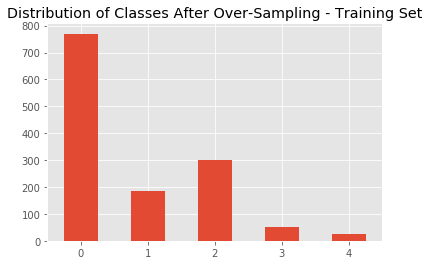

In [0]:
counts = pd.Series(y_train_balanced).value_counts(sort=False)
counts.plot(kind='bar', title='Distribution of Classes After Over-Sampling - Training Set', rot=0)
plt.show()

**FNN**

In [0]:
# Retrain the model with balanced training data
mod_fnn = load_model('models/fnn_init.h5')
nn_fit_eval(
    mod_fnn,
    train_generator_balanced,
    test_generator)

Epoch 1/15
21/21 [==============================] - 20s 939ms/step - loss: 6.5028 - acc: 0.5120
Epoch 2/15
21/21 [==============================] - 20s 929ms/step - loss: 6.7876 - acc: 0.5789
Epoch 3/15
21/21 [==============================] - 20s 931ms/step - loss: 6.7940 - acc: 0.5789
Epoch 4/15
21/21 [==============================] - 20s 934ms/step - loss: 6.8004 - acc: 0.5789
Epoch 5/15
21/21 [==============================] - 20s 929ms/step - loss: 6.7972 - acc: 0.5789
Epoch 00005: early stopping

Test loss: 4.701113033294678
Test accuracy: 0.7222222


**CNN**

In [0]:
# Retrain the model with balanced training data
mod_cnn = load_model('models/cnn_init.h5')
nn_fit_eval(
    mod_cnn,
    train_generator_balanced,
    test_generator)

Epoch 1/15
21/21 [==============================] - 70s 3s/step - loss: 1.3553 - acc: 0.5789
Epoch 2/15
21/21 [==============================] - 69s 3s/step - loss: 1.1362 - acc: 0.5789
Epoch 3/15
21/21 [==============================] - 68s 3s/step - loss: 1.1218 - acc: 0.5789
Epoch 4/15
21/21 [==============================] - 69s 3s/step - loss: 1.1276 - acc: 0.5789
Epoch 00004: early stopping

Test loss: 0.9480130553245545
Test accuracy: 0.7222222


Both models perform the same on the test set as before.

## Summary

All the models cannot beat baseline. I think it's due to two reasons. One is that there are not enough images available. The other is that the data is imbalanced, which can be very difficult to handle.